# Convolutions
In the last notebook we built a a fully connected neural network to classify RGB images of 32x32 pixels. In a fully connected network any unit of a layer is connected to all the units in the next layer. We saw that there are two problems with that network. One problem is that the network does not scale well with the size of the image. The second problem is that the network is not translation invariant: the same object translated in a different position is treated like a different one so the network is less efficient. A solution to this second problem would be data augmentation, applying affine transformation to the image to have a larger training dataset, but the first problem could not be addressed. The solution is to connect the units that are spatially related, such as the nearest neighbors. This solution can solve both problems since the number of parameters to be learnt would be less and the size of the image would not be a problem since for each pixel only those that are close would be used. A convolution is a linear operation that is applied to a set of neighboring units and returns a value. A convolution has a kernel, a number of input channels and output channels. For instance, when dealing with RGB images, a convolution layer has 3 input channels, a kernel whose size can be 3x3, and a number of output channels, e.g. 16. The output channels may be used to detect different kind of features in the images. The size of the weight tensor that represent our convolution would be 

input_channels x kernel_size x output_channels = 3 x (3 x 3) x 16

We have also to add the bias parameters, one for each output channel. 

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import collections

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms

In order to see all this in action we will download the CIFAR10 datasets, that contains 50000 RGB 32x32 images. We will also apply two transformations, one to change the images into PyTorch tensors and one to normalize the pixels value.

In [ ]:
from torchvision import datasets
data_path = 'data-unversioned/p1ch8/'
cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data-unversioned/p1ch8/cifar-10-python.tar.gz to data-unversioned/p1ch8/
Files already downloaded and verified


In order to normalize the data we have to compute the mean and the standard deviation

In [ ]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [ ]:
imgs = torch.stack([img_t for img_t, _ in tensor_cifar10], dim=3)
imgs.shape

torch.Size([3, 32, 32, 50000])

In [ ]:
mean = imgs.view(3, -1).mean(dim=1)
mean

tensor([0.4914, 0.4822, 0.4465])

In [ ]:
std = imgs.view(3, -1).std(dim=1)
std

tensor([0.2470, 0.2435, 0.2616])

Now we can transform rhe images into Python tensors and to normalize the pixels value

In [ ]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [ ]:
transformed_cifar10_val = datasets.CIFAR10(
    data_path, train=False, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]))

In [ ]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

Now we filter the data to use only the images that represent airplanes or birds

In [ ]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']
cifar2 = [(img, label_map[label]) for img, label in transformed_cifar10 if label in [0, 2]]
cifar2_val = [(img, label_map[label]) for img, label in transformed_cifar10_val if label in [0, 2]]
len(cifar2), len(cifar2_val)

(10000, 2000)

As said in the introduction, a convolution is a linear transformation that is applied to an image. The transformation is implemented as a matrix whose parameters is given as a product of input_channel x kernel_size x output_channel. The number of parameters to be learnt are much less than for a fully connected network and does not depend on the size of the input images. We add a padding=1 so that the convolution can be applied also to the pixel on the border of the image. The size of each output feature (channel) for each dimension, i.e. height and width, is given by the formula (see ref.1)

$$n_{output} = \frac{n_{input} + 2p - f}{s} + 1$$

where $n_{input}$ is the height (width) of the input image (e.g. 32), p is the padding (e.g. p = 1), f is the kernel size (e.g. 3), and s is the stride or step, that is the number of pixels the kernel is shifted horizontally (vertically). 

In [ ]:
input_channels = 3
output_channels = 16
kernel_size = 3
conv = nn.Conv2d(input_channels, output_channels, kernel_size=kernel_size, padding=1)
conv

Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [ ]:
conv.weight.shape, conv.bias.shape

(torch.Size([16, 3, 3, 3]), torch.Size([16]))

We can apply the convolution to an image (a tensor that represents an image). The output is a new tensor with 16 channels and a size of 32x32 pixels, the same size of the input images.

In [ ]:
img, _ = cifar2[0]
output = conv(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 16, 32, 32]))

We can draw one of the output channels

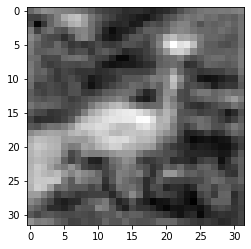

In [ ]:
plt.imshow(output[0, 0].detach(), cmap='gray')
plt.show()

## Testing a convolution
We have built the structure of our convolution but we still have to define it. For instance we want our convolution to compute the mean of the 3x3 pixels that are adjacent of any pixel in our images. We set the bias to zero to simplify the convolution. As we can see, and as expected, the convolution produces a blurred version of the image.

In [ ]:
with torch.no_grad():
    conv.bias.zero_()
    
with torch.no_grad():
    conv.weight.fill_(1.0 / 9.0)

In [ ]:
output = conv(img.unsqueeze(0))

In [ ]:
def plot_convolution(img, output):
  plt.figure(figsize=(10, 4.8))
  ax1 = plt.subplot(1, 2, 1)
  plt.title('output')
  plt.imshow(output[0, 0].detach(), cmap='gray')
  plt.subplot(1, 2, 2, sharex=ax1, sharey=ax1) 
  plt.imshow(img.mean(0), cmap='gray') 
  plt.title('input') 
  plt.show()

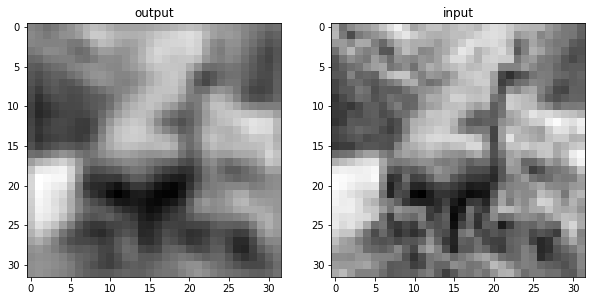

In [ ]:
plot_convolution(img, output)

Now we implement a different convolution that is used as a vertical edge detector

In [ ]:
with torch.no_grad():
    conv.weight[:] = torch.tensor([[-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0],
                                   [-1.0, 0.0, 1.0]])
    conv.bias.zero_()

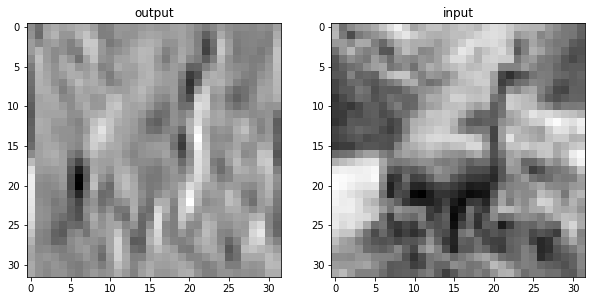

In [ ]:
output = conv(img.unsqueeze(0))
plot_convolution(img, output)

## Max pooling
Each kernel, that is learnt during the training process, extract or enhance a feature of the image, its vertical or horizontal structure, mean value, or some other pattern that occurs in it, and the output is saved in one of the channels that have been defined at each particular convolutional layer of the network. The feautures that are learnt with the kerlnels are local and translation invariant but we do not want to miss the characteristics of the full image, let's say missing the forest for the trees. We could use all the pixels of the image but we would have agaon the same problem of scalability that we solved with the convolution. The idea is then to compute a downsampled feature of the image, like considering only the highest values of a set of adjacent pixels. For instance, we can downsample an image by half using a 2x2 neighborhood 

In [ ]:
pool = nn.MaxPool2d(2)
output = pool(img.unsqueeze(0))
img.unsqueeze(0).shape, output.shape

(torch.Size([1, 3, 32, 32]), torch.Size([1, 3, 16, 16]))

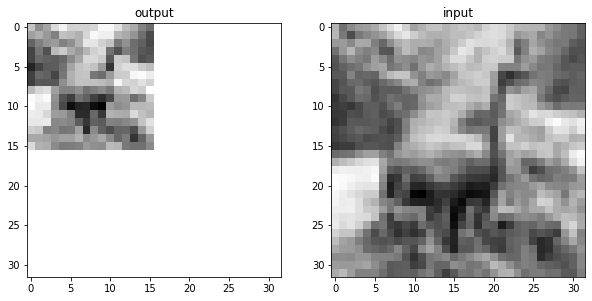

In [ ]:
plot_convolution(img, output)

## Convolutional + max pooling layer
We want to create a CNN by putting together a sequence of convolutional and max pooling layers. The first type of layers will extract local patterns in the input data and the max pooling layer will reduce the size of the features channels preserving the overall structure. We might start by creating a sequence of layers like we did to build our simple fully connected neural network, this time using convolutional and max pooling layers. For instance we can add a first convolutional layer with 3 channels (RGB), a 3x3 kernel and 16 output channels (features). The convolution is a linear transformation so we apply an activation function to its output. This way we would end up with more than 5 time the amount of the input data, since the convolution does not change its size, so we apply a max pooling operator that will reduce the size of the data by half. Now these 16 output channels are used as input channels for the next convolutional layer. We set this 2nd convolutional layer to have 8 output channels and the same 3x3 kernel size, an activation function and then a max pooling layer that will reduce the size of the output channels by half. In order to use the network to separate images containing airplanes from those containing birds we need to connect the output of the second max pooling layer to a layer that implements a linear transformation and then a softmax. Unfortunately there is no way to implement a sequence that conects the output of a convolutional layer to a linear one. We have to reshape a 8x8x8 3D tensor into a one dimensional array of size 512 but the Sequential class does not know how to do that and we have to implement that transformation ourselves. If we try to use the network as said we will end up in an error. 

In [ ]:
layer1_input_channels = 3
layer1_output_channels = 16
layer2_input_channels = 16
layer2_output_channels = 8

model = nn.Sequential(
            nn.Conv2d(layer1_input_channels, layer1_output_channels, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            nn.Conv2d(layer2_input_channels, layer2_output_channels, kernel_size=3, padding=1),
            nn.Tanh(),
            nn.MaxPool2d(2),
            # ...something missing here to map a 8x8x8 3D tensor to an array of size 512
            nn.Linear(8 * 8 * 8, 32),
            nn.Tanh(),
            nn.Linear(32, 2))

In [ ]:
#model(img.unsqueeze(0))

In order to overcome the limit of the Sequential network we have to implement a new one. The missing element is implemented here in the forward() function in which a three dimensional tensor of size 8x8x8 (Channels x Height x Width) is mapped to a one dimensional array of size 512. In the _init_ function are defined all the layer used in the network: conv1, act1, pool1, then conv2, act2, pool2 and finally the fully connected layers fc1, act3 and fc2. In the forward function the layer are called and after pool2 returns the transformation that was missing in Sequential is applied. The submodules in the definition of our network implement the convolutional and the fully connected layers while the activation function and the max pooling that are functional and do not change the input parameters are defined in the forward function.

In [ ]:
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(layer1_input_channels, layer1_output_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(layer2_input_channels, layer2_output_channels, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 8 * 8, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 8 * 8) # implements the missing element that maps a 3D 8x8x8 tensor to a one dimensional array of size 512
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

We can see the number of parameters used in each submodule of our network. The first section of the network, the output features (channels) of the 1st convolutional layer have a total size of 16x32x32 = 16384. These parameters are mapped to a fully connected layer of 32 inputs after the 2nd max pooling and then to a second fully connected layer that maps the 32 inputs to two outputs used for the final classification airplane/bird.

In [ ]:
model = Net()

numel_list = [p.numel() for p in model.parameters()]
sum(numel_list), numel_list

(18090, [432, 16, 1152, 8, 16384, 32, 64, 2])

We test our model on one image (tensor). We should get two numbers

In [ ]:
model = Net()
model(img.unsqueeze(0))

tensor([[-0.1262,  0.1415]], grad_fn=<AddmmBackward0>)

## Training the convolutional neural network
The training loop is no different than the one we have used for our simple fully connected neural network. The model of course is now our customized convolutional neural network. The training loop mainly takes the batch data, computes the forward pass and the loss, computes the gradient with respect to the parameters and updates the optimizer to reduce the loss. here we define our training loop

In [ ]:
import datetime 

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  
        loss_train = 0.0
        
        for imgs, labels in train_loader: 
            outputs = model(imgs) 
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item() 

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

then we use it with our dataset of airplanes and birds. We performs 100 epochs. The network is fast enough that can be run using a CPU and complete the training in less than 8 minutes on Google Colab (5 minutes with a GPU). 

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True) 

optimizer = optim.SGD(model.parameters(), lr=1e-2) 
loss_fn = nn.CrossEntropyLoss()

training_loop( 
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2022-11-19 14:44:28.867767 Epoch 1, Training loss 0.5604534766096978
2022-11-19 14:44:56.689462 Epoch 10, Training loss 0.33144746426564115
2022-11-19 14:45:29.928565 Epoch 20, Training loss 0.28480740555912065
2022-11-19 14:46:00.847349 Epoch 30, Training loss 0.2587169788920196
2022-11-19 14:46:32.504491 Epoch 40, Training loss 0.23879939004494127
2022-11-19 14:47:04.073646 Epoch 50, Training loss 0.2239389695274602
2022-11-19 14:47:34.990778 Epoch 60, Training loss 0.2080535505227982
2022-11-19 14:48:06.663049 Epoch 70, Training loss 0.19428594135175084
2022-11-19 14:48:37.767518 Epoch 80, Training loss 0.1792195502929627
2022-11-19 14:49:09.494982 Epoch 90, Training loss 0.16804902217570383
2022-11-19 14:49:41.488197 Epoch 100, Training loss 0.1533805353056853


## Model accuracy
The loss for the training data after 100 epochs is quite low but we have to see what happens with the validation set. We want to compute the model accuracy that depends on the ratio of the missclassifications m over the number of validation examples

$$accuracy = 1 - \frac{m}{N_{val}}$$

In [ ]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=False)
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)
all_acc_dict = collections.OrderedDict()

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # we do not need the gradient since we are not going to update the parameters
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) 
                total += labels.shape[0] 
                correct += int((predicted == labels).sum()) 

        print("Accuracy {}: {:.2f}".format(name , correct / total))

all_acc_dict['baseline'] = validate(model, train_loader, val_loader)

Accuracy train: 0.94
Accuracy val: 0.88


We can see that our convolutional network performs better (higher accuracy) than our previous fully connected network, and it has less parameters so that it can be run even with a CPU in a much shorter time.

## Saving the model

In [ ]:
torch.save(model.state_dict(), data_path + 'birds_vs_airplanes.pt')

In [ ]:
loaded_model = Net()  # <1>
loaded_model.load_state_dict(torch.load(data_path + 'birds_vs_airplanes.pt'))

<All keys matched successfully>

## Model design
PyTorch allows us to set the number of units, input and output parameters for each layer and we have to learn the mechanics of building a model that can solve the problem at hand from classifying pictures to translating a text. We begin by setting the output channels of the first layer from 16 to 32. We have to types of layers in out network: convolutional and fully connected. We know that the height and width of the output tensor of a convolution is the same as the input if the stride is 1. We have to do some little math to make the output of a layer match with the input of the next one.   

In [ ]:
input_width = 32
input_height = 32
layer1_input_channels = 3
layer1_output_channels = 32
layer2_input_channels = layer1_output_channels
layer2_output_channels = 16
num_max_pooling_layers = 2
layer3_input = layer2_output_channels * (input_width // (2 * num_max_pooling_layers)) * (input_height // (2* num_max_pooling_layers))
layer3_input

1024

In [ ]:
layer3_output = 32
layer4_input = layer3_output 
layer4_output = 2

### Increasing the width of the model
We can increase the capacity of our model without adding more layers by increasing their number of features (channels) 

In [ ]:
class NetWidth(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(layer1_input_channels, layer1_output_channels, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(layer2_input_channels, layer2_output_channels, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(layer3_input, layer3_output)
        self.fc2 = nn.Linear(layer4_input, layer4_output)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, layer3_input)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

We can compute the total number of parameters of our new model

In [ ]:
model = NetWidth()
sum(p.numel() for p in model.parameters())

38386

We can train our new model on the same data. We might have some overfitting since the model has more parameters to fit the training data more closely. Since the number of parameters has doubled we expect a longer training time and in this case using a GPU would save time. (CPU->15 mins.) 

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["width"] = validate(model, train_loader, val_loader)

2022-11-19 14:52:53.722616 Epoch 1, Training loss 0.5412382534734762
2022-11-19 14:53:47.450178 Epoch 10, Training loss 0.31395211644992704
2022-11-19 14:54:47.443445 Epoch 20, Training loss 0.2741255258109159
2022-11-19 14:55:46.987525 Epoch 30, Training loss 0.24608558117394236
2022-11-19 14:56:53.693664 Epoch 40, Training loss 0.21846291062178885
2022-11-19 14:57:53.977755 Epoch 50, Training loss 0.19208269533078381
2022-11-19 14:58:54.866544 Epoch 60, Training loss 0.1680906084929682
2022-11-19 15:00:01.279167 Epoch 70, Training loss 0.14567225464400213
2022-11-19 15:01:09.194780 Epoch 80, Training loss 0.12424435410767225
2022-11-19 15:02:14.518390 Epoch 90, Training loss 0.10417688411369824
2022-11-19 15:03:14.117531 Epoch 100, Training loss 0.08596264718064836
Accuracy train: 0.96
Accuracy val: 0.90


## Regularization
We look for ways to improve the optimization (reduce loss) and improve the generalization (accuracy on the validation set). There are many techniques developed over the years. We look at some of them by making some changes to our training loop.

### L2 regularization
We start with L2 regularization that decreases the weights by a factor that depends on the total value of the parameters.

In [ ]:
def training_loop_l2reg(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0
        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)

            l2_lambda = 0.001
            l2_norm = sum(p.pow(2.0).sum() for p in model.parameters()) 
            loss = loss + l2_lambda * l2_norm

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))


In [ ]:
training_loop_l2reg(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

all_acc_dict["L2 reg"] = validate(model, train_loader, val_loader)

2022-11-19 15:04:00.849348 Epoch 1, Training loss 0.15137871720228985
2022-11-19 15:04:55.573131 Epoch 10, Training loss 0.14224358050117067
2022-11-19 15:05:59.839994 Epoch 20, Training loss 0.13385409026578732
2022-11-19 15:07:00.927793 Epoch 30, Training loss 0.1269344827931398
2022-11-19 15:08:01.913946 Epoch 40, Training loss 0.12117952165330291
2022-11-19 15:09:04.311465 Epoch 50, Training loss 0.11644603971652924
2022-11-19 15:10:06.025709 Epoch 60, Training loss 0.11250954353885287
2022-11-19 15:11:08.387216 Epoch 70, Training loss 0.1092314297796055
2022-11-19 15:12:10.048749 Epoch 80, Training loss 0.1065088181643729
2022-11-19 15:13:11.744242 Epoch 90, Training loss 0.10421275176629899
2022-11-19 15:14:13.842449 Epoch 100, Training loss 0.10226261829304847
Accuracy train: 0.99
Accuracy val: 0.90


### Dropout
The idea here is to randomly set to zero a subset of the output of a layer. The removal of the subset should improve the generalization of the network and the accuracy on the validation set.

In [ ]:
class NetDropout(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_dropout = nn.Dropout2d(p=0.4)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv2_dropout = nn.Dropout2d(p=0.4)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = self.conv1_dropout(out)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = self.conv2_dropout(out)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDropout(n_chans1=32)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["dropout"] = validate(model, train_loader, val_loader)

2022-11-19 15:15:27.425992 Epoch 1, Training loss 0.5725564104356583
2022-11-19 15:16:23.816621 Epoch 10, Training loss 0.37704491359033404
2022-11-19 15:17:26.010497 Epoch 20, Training loss 0.35098634603296874
2022-11-19 15:18:30.036001 Epoch 30, Training loss 0.32635260435046665
2022-11-19 15:19:40.077996 Epoch 40, Training loss 0.3143630323895983
2022-11-19 15:20:49.707778 Epoch 50, Training loss 0.29657437865901143
2022-11-19 15:21:50.404734 Epoch 60, Training loss 0.28970725464213426
2022-11-19 15:22:51.472079 Epoch 70, Training loss 0.273337601571326
2022-11-19 15:23:53.763304 Epoch 80, Training loss 0.2632983414230833
2022-11-19 15:24:55.673566 Epoch 90, Training loss 0.25647510754264846
2022-11-19 15:25:56.881869 Epoch 100, Training loss 0.24402525176288217
Accuracy train: 0.89
Accuracy val: 0.88


### Batch normalization

In [ ]:
class NetBatchNorm(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv1_batchnorm = nn.BatchNorm2d(num_features=n_chans1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, 
                               padding=1)
        self.conv2_batchnorm = nn.BatchNorm2d(num_features=n_chans1 // 2)
        self.fc1 = nn.Linear(8 * 8 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = self.conv1_batchnorm(self.conv1(x))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = self.conv2_batchnorm(self.conv2(out))
        out = F.max_pool2d(torch.tanh(out), 2)
        out = out.view(-1, 8 * 8 * self.n_chans1 // 2)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetBatchNorm(n_chans1=32)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["batch_norm"] = validate(model, train_loader, val_loader)

2022-11-19 15:27:42.072632 Epoch 1, Training loss 0.46778581799215574
2022-11-19 15:29:04.512295 Epoch 10, Training loss 0.26532914873900687
2022-11-19 15:30:31.935123 Epoch 20, Training loss 0.20431593829279493
2022-11-19 15:31:56.276903 Epoch 30, Training loss 0.15622139570249874
2022-11-19 15:33:17.231736 Epoch 40, Training loss 0.1152666056896471
2022-11-19 15:34:42.685201 Epoch 50, Training loss 0.0803803472904263
2022-11-19 15:36:10.469307 Epoch 60, Training loss 0.05477522901751718
2022-11-19 15:37:36.579906 Epoch 70, Training loss 0.03722589110338669
2022-11-19 15:39:01.238355 Epoch 80, Training loss 0.02423748631137097
2022-11-19 15:40:21.217730 Epoch 90, Training loss 0.01664415769320527
2022-11-19 15:41:40.650840 Epoch 100, Training loss 0.011130213010818905
Accuracy train: 0.99
Accuracy val: 0.88


### Depth
The other way to increase the capacity of a network is by adding layers, that is increasing its depth. Adding layers can increase the ability of the network to learn more abstract concepts and in general its ability to distinguish patterns in the data. Increasing the width of a network doesn't change the function y = g(f(x)), while increasing its depth does change the function to y = g(f(h(x))). The function g() learns more specific features of the input after it has been processed by more layers (nested functions)

In [ ]:
class NetDepth(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out = F.max_pool2d(torch.relu(self.conv3(out)), 2)
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetDepth(n_chans1=32)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["depth"] = validate(model, train_loader, val_loader)

2022-11-19 15:42:28.349051 Epoch 1, Training loss 0.6873320386667919
2022-11-19 15:43:19.065015 Epoch 10, Training loss 0.3456402107788499
2022-11-19 15:44:22.490986 Epoch 20, Training loss 0.2976960244641942
2022-11-19 15:45:24.286729 Epoch 30, Training loss 0.2643616833504598
2022-11-19 15:46:25.496646 Epoch 40, Training loss 0.23282873492901493
2022-11-19 15:47:21.856852 Epoch 50, Training loss 0.20252967464506247
2022-11-19 15:48:27.684371 Epoch 60, Training loss 0.17326948687339286
2022-11-19 15:49:33.314233 Epoch 70, Training loss 0.14644002064967612
2022-11-19 15:50:30.813003 Epoch 80, Training loss 0.1202080894000591
2022-11-19 15:51:36.075320 Epoch 90, Training loss 0.09446415273104883
2022-11-19 15:52:39.265491 Epoch 100, Training loss 0.07309810786395315
Accuracy train: 0.95
Accuracy val: 0.89


### ResNet
Adding layers to a network increases the number of parameters to be learned and makes the training more difficult. One problem is due to the floating-point approximation. Since a machine can handle only a certain number of digits (e.g. 64) a float number such as the derivatives of the loss function be become too small and random. One technique to avoid such problem in deep networks is to skip some connections that is adding the input to the output of a layer (or block of layers)

In [ ]:
class NetRes(nn.Module):
    def __init__(self, n_chans1=32):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n_chans1, n_chans1 // 2, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n_chans1 // 2, n_chans1 // 2, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(4 * 4 * n_chans1 // 2, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = F.max_pool2d(torch.relu(self.conv2(out)), 2)
        out1 = out
        out = F.max_pool2d(torch.relu(self.conv3(out)) + out1, 2) # skip connection
        out = out.view(-1, 4 * 4 * self.n_chans1 // 2)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [ ]:
model = NetRes(n_chans1=32)
optimizer = optim.SGD(model.parameters(), lr=1e-2)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res"] = validate(model, train_loader, val_loader)

2022-11-19 15:53:20.980931 Epoch 1, Training loss 0.6681512670152506
2022-11-19 15:54:11.810120 Epoch 10, Training loss 0.3296421105694619
2022-11-19 15:55:08.924718 Epoch 20, Training loss 0.28321667214867413
2022-11-19 15:56:05.532917 Epoch 30, Training loss 0.24592295535810435
2022-11-19 15:57:02.139664 Epoch 40, Training loss 0.21397957006457505
2022-11-19 15:58:03.158979 Epoch 50, Training loss 0.18613878974489345
2022-11-19 15:59:01.671374 Epoch 60, Training loss 0.16086240321587605
2022-11-19 16:00:02.605767 Epoch 70, Training loss 0.13638786860047633
2022-11-19 16:01:10.236293 Epoch 80, Training loss 0.11244413985093688
2022-11-19 16:02:13.090530 Epoch 90, Training loss 0.08973045876712367
2022-11-19 16:03:15.576034 Epoch 100, Training loss 0.07103912247000796
Accuracy train: 0.97
Accuracy val: 0.91


## Building very deep models
We can easily build very deep networks by adding blocks of layers such as (Conv2d, ReLu, Con2d) + skip connection. Once we have defined a block we can then build a network as a sequence of such blocks. A block with a skip connection is called residual block. We implement this idea with two classes, one for the block

In [ ]:
class ResBlock(nn.Module):
    def __init__(self, n_chans):
        super(ResBlock, self).__init__()
        self.conv = nn.Conv2d(n_chans, n_chans, kernel_size=3, padding=1, bias=False) 
        self.batch_norm = nn.BatchNorm2d(num_features=n_chans)
        torch.nn.init.kaiming_normal_(self.conv.weight, nonlinearity='relu') 
        torch.nn.init.constant_(self.batch_norm.weight, 0.5)
        torch.nn.init.zeros_(self.batch_norm.bias)

    def forward(self, x):
        out = self.conv(x)
        out = self.batch_norm(out)
        out = torch.relu(out)
        return out + x

Then we define our network as a sequence of the blocks we have previously defined

In [ ]:
class NetResDeep(nn.Module):
    def __init__(self, n_chans1=32, n_blocks=10):
        super().__init__()
        self.n_chans1 = n_chans1
        self.conv1 = nn.Conv2d(3, n_chans1, kernel_size=3, padding=1)
        self.resblocks = nn.Sequential(*(n_blocks * [ResBlock(n_chans=n_chans1)]))
        self.fc1 = nn.Linear(8 * 8 * n_chans1, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):
        out = F.max_pool2d(torch.relu(self.conv1(x)), 2)
        out = self.resblocks(out)
        out = F.max_pool2d(out, 2)
        out = out.view(-1, 8 * 8 * self.n_chans1)
        out = torch.relu(self.fc1(out))
        out = self.fc2(out)
        return out
    


In [ ]:
model = NetResDeep(n_chans1=32, n_blocks=100)
optimizer = optim.SGD(model.parameters(), lr=3e-3)
loss_fn = nn.CrossEntropyLoss()

training_loop(
    n_epochs = 100,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)
all_acc_dict["res deep"] = validate(model, train_loader, val_loader)

2022-11-19 16:11:13.849536 Epoch 1, Training loss 2.6594315809049425
2022-11-19 16:53:09.990983 Epoch 10, Training loss 0.3766248545069603
2022-11-19 17:38:38.230427 Epoch 20, Training loss 0.2928609885987203
2022-11-19 18:23:43.950053 Epoch 30, Training loss 0.23445282288038047


## Comparing the accuracy of the models

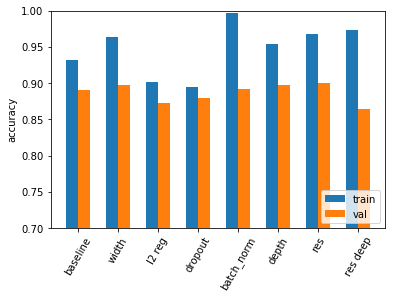

In [ ]:
trn_acc = [v['train'] for k, v in all_acc_dict.items()]
val_acc = [v['val'] for k, v in all_acc_dict.items()]

width =0.3
plt.bar(np.arange(len(trn_acc)), trn_acc, width=width, label='train')
plt.bar(np.arange(len(val_acc))+ width, val_acc, width=width, label='val')
plt.xticks(np.arange(len(val_acc))+ width/2, list(all_acc_dict.keys()), rotation=60)
plt.ylabel('accuracy')
plt.legend(loc='lower right')
plt.ylim(0.7, 1)
plt.savefig('accuracy_comparison.png', bbox_inches='tight')
plt.show()


## References
1. [Dumoulin, Visin - A guide to convolution arithmetic for deep learning](https://arxiv.org/abs/1603.07285)  